# LIBRAIRIES

In [1]:
import numpy as np
import pandas as pd

import scorecardpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import warnings

# IMPORT ET PREPROCESS

In [2]:
data = pd.read_csv('data_projet_dataviz_storytelling.csv', sep=',')
data

,Age,Sexe,CSP,Revenu,Niveau_etudes,Proprietaire_locataire,Departement,Anciennete,Nombre_compte_investissement,Nombre_compte_epargne,...,Nombre_devis_en_ligne,Nombre_de_visite_agence,Nombre_appel_telephonique,Nombre_mail,Nombre_reclamation,Note_satisfaction_2022,Note_satisfaction_2023,Nombre_comptes,Nombre_cartes,Cluster
0,53,Femme,Cadres,77845,Master,Locataire,Yvelines,14,1,0,...,0,0,3,7,0,3,3,1,1,1
1,45,Femme,Agriculteurs,54897,Master,Propriétaire,Hauts-de-Seine,9,0,0,...,1,0,1,6,1,3,4,0,1,1
2,44,Homme,Cadres,72991,Master,Locataire,Paris,11,0,0,...,2,0,1,15,1,4,4,0,0,1
3,41,Femme,Agriculteurs,54050,Doctorat,Propriétaire,Yvelines,13,0,2,...,2,0,0,18,4,4,4,2,2,1
4,59,Homme,Artisans,77230,Master,Propriétaire,Paris,1,1,0,...,2,0,1,12,0,5,4,1,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64368,10,Femme,Entrepreneur,26501,Master,Propriétaire,Essonne,0,1,0,...,1,0,1,2,0,3,3,1,0,3
64369,33,Femme,Employés,52072,Licence,Locataire,Essonne,1,1,0,...,0,0,0,0,3,3,2,1,0,3
64370,21,Homme,Artisans,47862,Inconnue,Propriétaire,Yvelines,1,0,1,...,1,1,0,0,3,2,3,1,1,3
64371,21,Homme,Entrepreneur,41412,Doctorat,Locataire,Yvelines,0,1,1,...,3,1,0,1,1,2,2,2,2,3


In [ ]:
data = data.copy()

# Exclure les clients avec Age < 18 ou Revenu < 0
data = data[(data['Age'] >= 18) & (data['Age'] >= 0)]
data = data[(data['Revenu'] >= 0)]

# Conversion des variables commençant par 'flag_' en booléen (True/False)
flag_cols = [col for col in data.columns if col.startswith('flag_')]
data[flag_cols] = data[flag_cols].astype(bool)

# Conversion des colonnes de type object en category
object_cols = data.select_dtypes(include='object').columns
data[object_cols] = data[object_cols].astype('category')

data['Cluster'] = data['Cluster'].astype('category')

# Création des flag de cluster
data['flag_cluster_1'] = data['Cluster'] == 1
data['flag_cluster_2'] = data['Cluster'] == 2
data['flag_cluster_3'] = data['Cluster'] == 3


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62750 entries, 0 to 64372
Data columns (total 40 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   Age                             62750 non-null  int64   
 1   Sexe                            62750 non-null  category
 2   CSP                             62750 non-null  category
 3   Revenu                          62750 non-null  int64   
 4   Niveau_etudes                   62750 non-null  category
 5   Proprietaire_locataire          62750 non-null  category
 6   Departement                     62750 non-null  category
 7   Anciennete                      62750 non-null  int64   
 8   Nombre_compte_investissement    62750 non-null  int64   
 9   Nombre_compte_epargne           62750 non-null  int64   
 10  Nombre_carte_prenium            62750 non-null  int64   
 11  Nombre_carte_classique          62750 non-null  int64   
 12  Solde_total_des_comptes

# DISCRETISATION DES QUANTI

In [5]:
# Suppress warnings to reduce verbosity
warnings.filterwarnings("ignore", category=FutureWarning)

for var in data.select_dtypes(include=['int64', 'float64']).columns:
    print()
    class_var = 'CLASS ' + var
    
    # Configuration du binning
    dt = data.copy()
    bins = sc.woebin(
        dt,
        y='flag_multibancarise',
        x=[var],
        method='tree',
        missing_coarse='missing'  # Crée une catégorie spéciale pour les NA
    )

    # Appliquer la transformation
    dt = sc.woebin_ply(dt,bins)
    
    # Création de la colonne discrétisée
    list_bins = [float(bin_str.split(',')[-1].strip(') ')) for bin_str in bins[var]['bin']][:-1]
    # Generate labels so that len(labels) == len(bins)
    bin_edges = [-np.inf] + list_bins + [np.inf]
    list_labels = []
    for i in range(len(bin_edges) - 1):
        if i == 0:
            list_labels.append(f"{var} < {bin_edges[1]}")
        elif i == len(bin_edges) - 2:
            list_labels.append(f"{var} >= {bin_edges[-2]}")
        else:
            list_labels.append(f"{bin_edges[i]} <= {var} < {bin_edges[i+1]}")

    data[class_var] = pd.cut(
        data[var], 
        bins=bin_edges, 
        labels=list_labels
    ).astype(str)
    data[class_var] = data[class_var].astype('category')


[INFO] creating woe binning ...
[INFO] converting into woe values ...

[INFO] creating woe binning ...
[INFO] converting into woe values ...

[INFO] creating woe binning ...
[INFO] converting into woe values ...

[INFO] creating woe binning ...
[INFO] converting into woe values ...

[INFO] creating woe binning ...
[INFO] converting into woe values ...

[INFO] creating woe binning ...
[INFO] converting into woe values ...

[INFO] creating woe binning ...
[INFO] converting into woe values ...

[INFO] creating woe binning ...
[INFO] converting into woe values ...

[INFO] creating woe binning ...
[INFO] converting into woe values ...

[INFO] creating woe binning ...
[INFO] converting into woe values ...

[INFO] creating woe binning ...
[INFO] converting into woe values ...

[INFO] creating woe binning ...
[INFO] converting into woe values ...

[INFO] creating woe binning ...
[INFO] converting into woe values ...

[INFO] creating woe binning ...
[INFO] converting into woe values ...

[INFO

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62750 entries, 0 to 64372
Data columns (total 66 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   Age                                   62750 non-null  int64   
 1   Sexe                                  62750 non-null  category
 2   CSP                                   62750 non-null  category
 3   Revenu                                62750 non-null  int64   
 4   Niveau_etudes                         62750 non-null  category
 5   Proprietaire_locataire                62750 non-null  category
 6   Departement                           62750 non-null  category
 7   Anciennete                            62750 non-null  int64   
 8   Nombre_compte_investissement          62750 non-null  int64   
 9   Nombre_compte_epargne                 62750 non-null  int64   
 10  Nombre_carte_prenium                  62750 non-null  int64   
 11  Nombre_

# STATS

In [7]:
cible = 'flag_multibancarise'

In [8]:
def calcul_cramersV_tschuprowT(conf_matrix, contingency_table):
    chi2_stat, p_val, dof, ex = stats.chi2_contingency(conf_matrix)
    n = conf_matrix.sum().sum()
    
    # return v et t
    return np.sqrt(chi2_stat / (n * (min(conf_matrix.shape) - 1))), np.sqrt(chi2_stat / (n * (min(contingency_table.shape) - 1)))

------------------------------------------------------------------------------------------
Analyse de la variable 'Cluster'



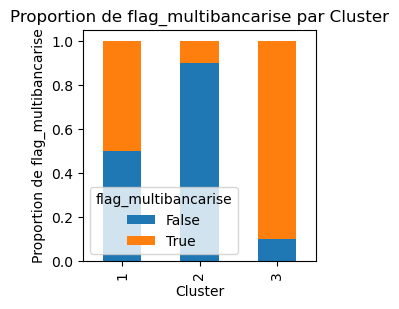


flag_multibancarise  False  True 
Cluster                          
1                     2039   2035
2                    45024   5028
3                      860   7764

Test du Khi-Deux - Chi2 stat: 27751.6081, p-value: 0.0000, df: 2 → Test significatif à 5%
T de Tschuprow : 0.6650
     Relation forte



------------------------------------------------------------------------------------------
Analyse de la variable 'CLASS Note_satisfaction_2023'



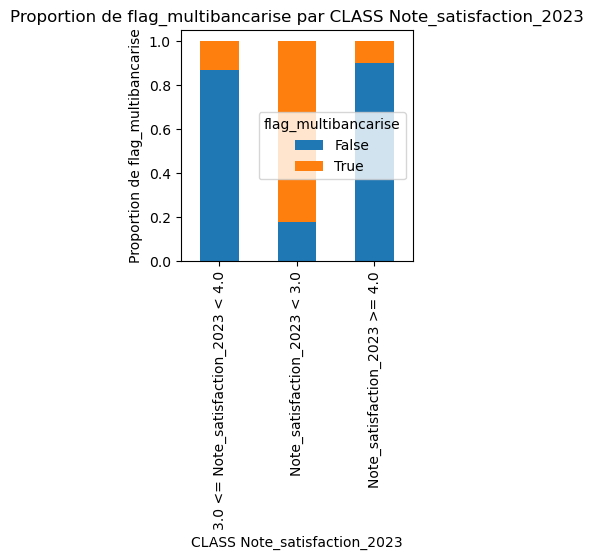


flag_multibancarise                  False  True 
CLASS Note_satisfaction_2023                     
3.0 <= Note_satisfaction_2023 < 4.0  23400   3552
Note_satisfaction_2023 < 3.0          1889   8810
Note_satisfaction_2023 >= 4.0        22634   2465

Test du Khi-Deux - Chi2 stat: 24722.4656, p-value: 0.0000, df: 2 → Test significatif à 5%
T de Tschuprow : 0.6277
     Relation forte



------------------------------------------------------------------------------------------
Analyse de la variable 'CLASS Nombre_de_visite_agence'



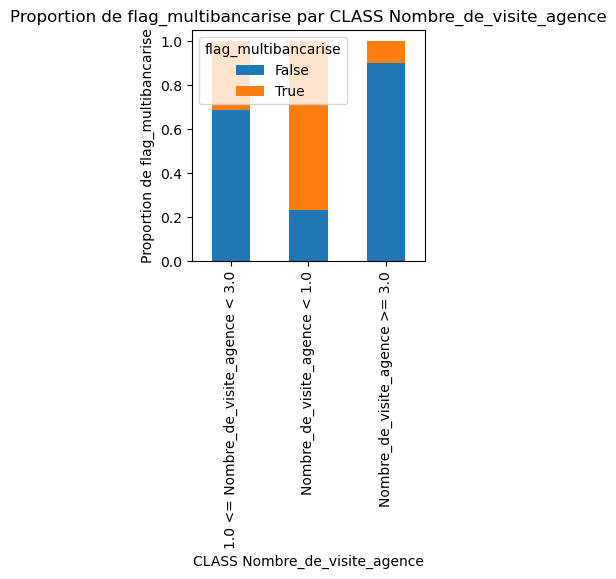


flag_multibancarise                   False  True 
CLASS Nombre_de_visite_agence                     
1.0 <= Nombre_de_visite_agence < 3.0   1124    515
Nombre_de_visite_agence < 1.0          2826   9394
Nombre_de_visite_agence >= 3.0        43973   4918

Test du Khi-Deux - Chi2 stat: 24242.2512, p-value: 0.0000, df: 2 → Test significatif à 5%
T de Tschuprow : 0.6216
     Relation forte



------------------------------------------------------------------------------------------
Analyse de la variable 'CLASS Age'



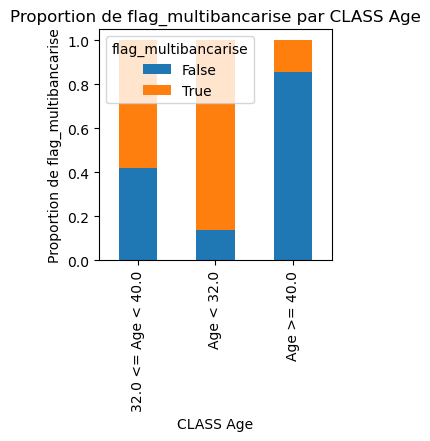


flag_multibancarise  False  True 
CLASS Age                        
32.0 <= Age < 40.0    1663   2281
Age < 32.0             811   5020
Age >= 40.0          45449   7526

Test du Khi-Deux - Chi2 stat: 17770.4744, p-value: 0.0000, df: 2 → Test significatif à 5%
T de Tschuprow : 0.5322
     Relation forte



------------------------------------------------------------------------------------------
Analyse de la variable 'CLASS Montant_credit_immobilier'



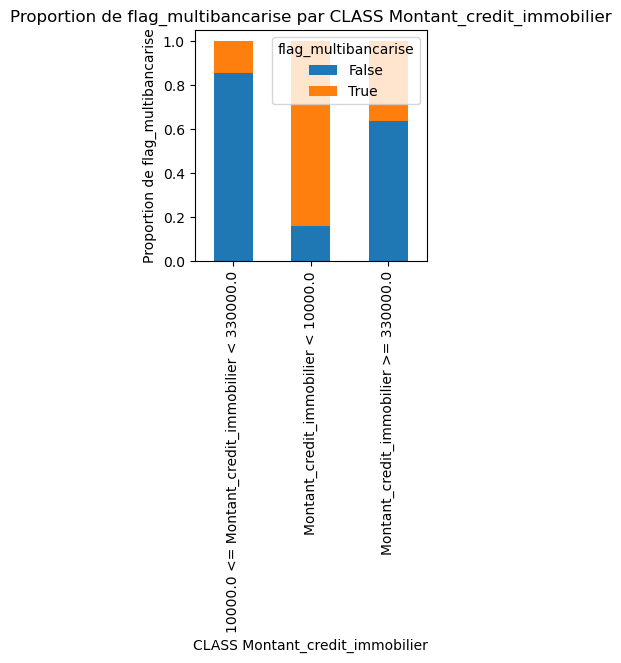


flag_multibancarise                              False  True 
CLASS Montant_credit_immobilier                              
10000.0 <= Montant_credit_immobilier < 330000.0  44663   7447
Montant_credit_immobilier < 10000.0               1169   6204
Montant_credit_immobilier >= 330000.0             2091   1176

Test du Khi-Deux - Chi2 stat: 17757.7605, p-value: 0.0000, df: 2 → Test significatif à 5%
T de Tschuprow : 0.5320
     Relation forte



------------------------------------------------------------------------------------------
Analyse de la variable 'CLASS Solde_total_des_comptes'



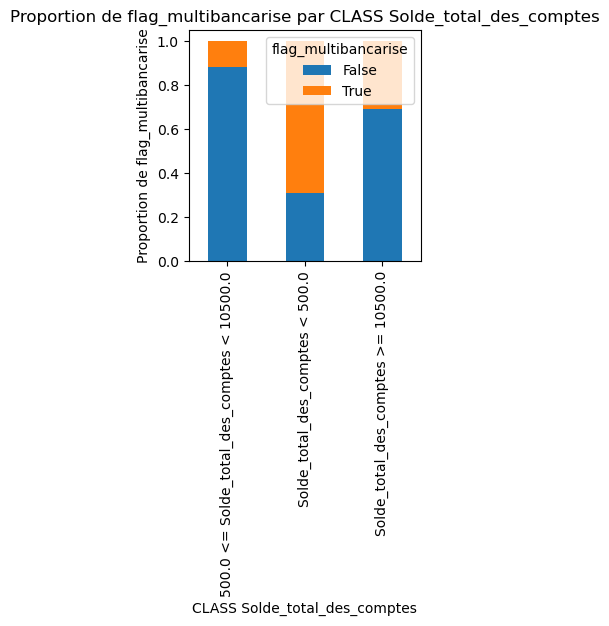


flag_multibancarise                         False  True 
CLASS Solde_total_des_comptes                           
500.0 <= Solde_total_des_comptes < 10500.0  41869   5636
Solde_total_des_comptes < 500.0              3579   8076
Solde_total_des_comptes >= 10500.0           2475   1115

Test du Khi-Deux - Chi2 stat: 17220.6944, p-value: 0.0000, df: 2 → Test significatif à 5%
T de Tschuprow : 0.5239
     Relation forte



------------------------------------------------------------------------------------------
Analyse de la variable 'CLASS Nombre_appel_telephonique'



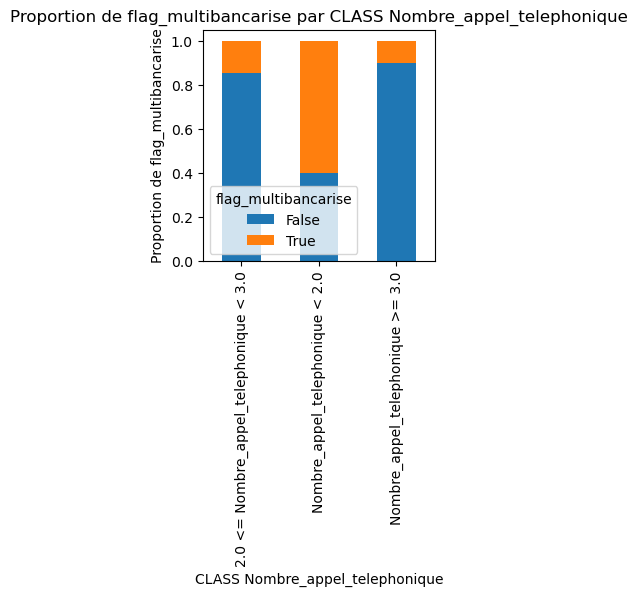


flag_multibancarise                     False  True 
CLASS Nombre_appel_telephonique                     
2.0 <= Nombre_appel_telephonique < 3.0   3244    566
Nombre_appel_telephonique < 2.0          6578   9885
Nombre_appel_telephonique >= 3.0        38101   4376

Test du Khi-Deux - Chi2 stat: 16440.6210, p-value: 0.0000, df: 2 → Test significatif à 5%
T de Tschuprow : 0.5119
     Relation forte



------------------------------------------------------------------------------------------
Analyse de la variable 'CLASS Nombre_defaut_paiement'



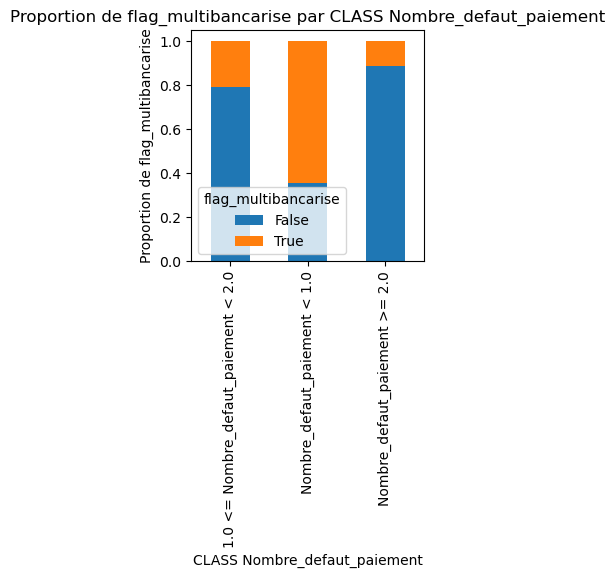


flag_multibancarise                  False  True 
CLASS Nombre_defaut_paiement                     
1.0 <= Nombre_defaut_paiement < 2.0   4528   1183
Nombre_defaut_paiement < 1.0          4767   8685
Nombre_defaut_paiement >= 2.0        38628   4959

Test du Khi-Deux - Chi2 stat: 16143.1098, p-value: 0.0000, df: 2 → Test significatif à 5%
T de Tschuprow : 0.5072
     Relation forte



------------------------------------------------------------------------------------------
Analyse de la variable 'CLASS Montant_epargne_mensuel'



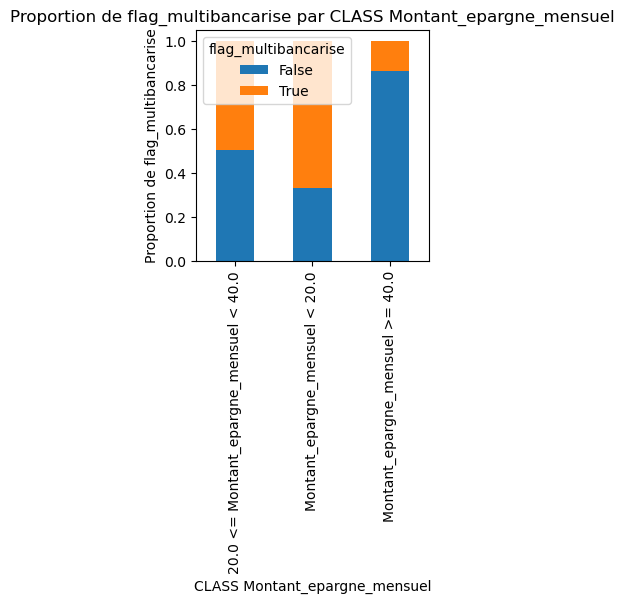


flag_multibancarise                     False  True 
CLASS Montant_epargne_mensuel                       
20.0 <= Montant_epargne_mensuel < 40.0   2341   2306
Montant_epargne_mensuel < 20.0           2805   5707
Montant_epargne_mensuel >= 40.0         42777   6814

Test du Khi-Deux - Chi2 stat: 13319.1177, p-value: 0.0000, df: 2 → Test significatif à 5%
T de Tschuprow : 0.4607
     Relation forte



------------------------------------------------------------------------------------------
Analyse de la variable 'CLASS Nombre_transaction_mensuelle'



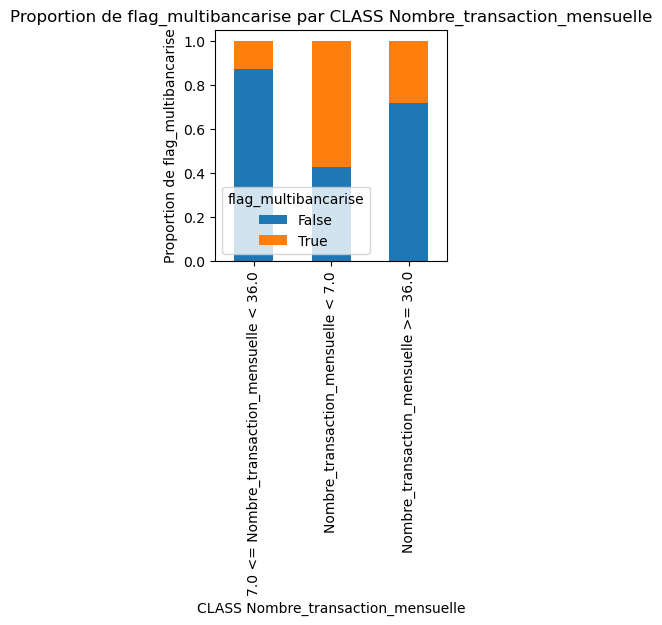


flag_multibancarise                         False  True 
CLASS Nombre_transaction_mensuelle                      
7.0 <= Nombre_transaction_mensuelle < 36.0  39193   5702
Nombre_transaction_mensuelle < 7.0           5913   8011
Nombre_transaction_mensuelle >= 36.0         2817   1114

Test du Khi-Deux - Chi2 stat: 11889.3394, p-value: 0.0000, df: 2 → Test significatif à 5%
T de Tschuprow : 0.4353
     Relation forte



------------------------------------------------------------------------------------------
Analyse de la variable 'CLASS Anciennete'



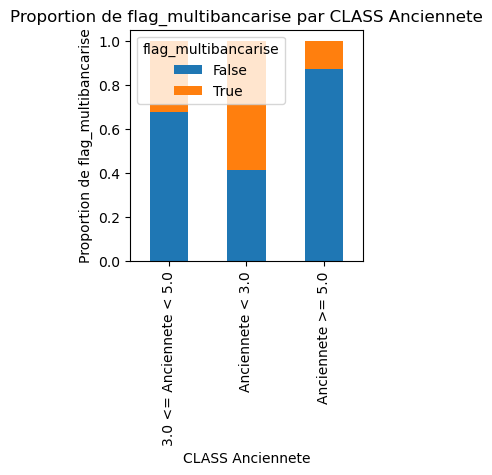


flag_multibancarise      False  True 
CLASS Anciennete                     
3.0 <= Anciennete < 5.0   3571   1725
Anciennete < 3.0          5117   7291
Anciennete >= 5.0        39235   5811

Test du Khi-Deux - Chi2 stat: 11594.5089, p-value: 0.0000, df: 2 → Test significatif à 5%
T de Tschuprow : 0.4299
     Relation forte



------------------------------------------------------------------------------------------
Analyse de la variable 'CLASS Nombre_comptes'



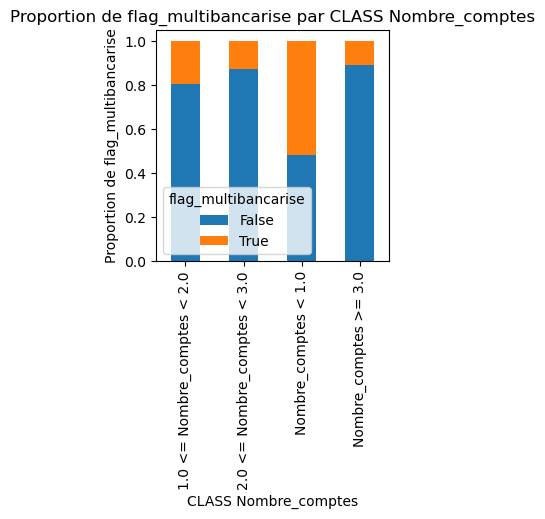


flag_multibancarise          False  True 
CLASS Nombre_comptes                     
1.0 <= Nombre_comptes < 2.0  10948   2656
2.0 <= Nombre_comptes < 3.0  12721   1854
Nombre_comptes < 1.0          7709   8332
Nombre_comptes >= 3.0        16545   1985

Test du Khi-Deux - Chi2 stat: 9927.1039, p-value: 0.0000, df: 3 → Test significatif à 5%
T de Tschuprow : 0.3977
     Relation forte



------------------------------------------------------------------------------------------
Analyse de la variable 'CLASS Nombre_connexion_application'



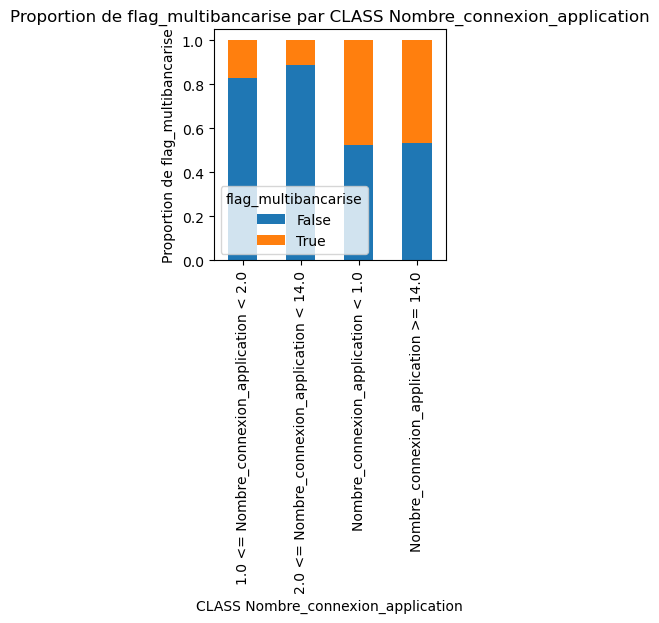


flag_multibancarise                         False  True 
CLASS Nombre_connexion_application                      
1.0 <= Nombre_connexion_application < 2.0    4520    927
2.0 <= Nombre_connexion_application < 14.0  32577   4111
Nombre_connexion_application < 1.0           9260   8421
Nombre_connexion_application >= 14.0         1566   1368

Test du Khi-Deux - Chi2 stat: 9772.6660, p-value: 0.0000, df: 3 → Test significatif à 5%
T de Tschuprow : 0.3946
     Relation forte



------------------------------------------------------------------------------------------
Analyse de la variable 'CLASS Nombre_devis_en_ligne'



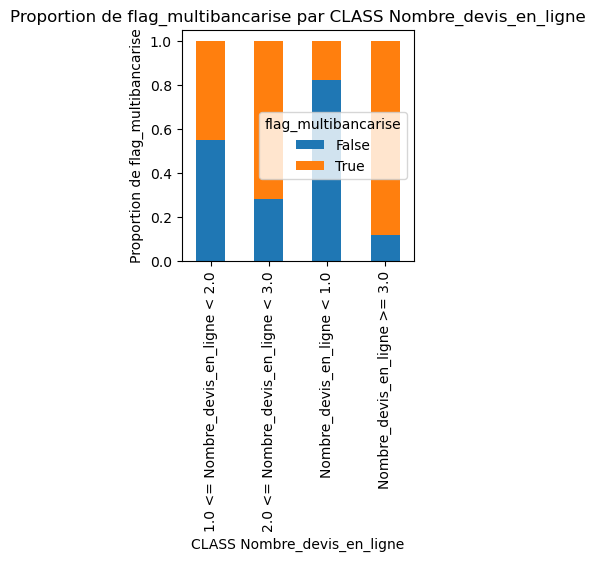


flag_multibancarise                 False  True 
CLASS Nombre_devis_en_ligne                     
1.0 <= Nombre_devis_en_ligne < 2.0   2840   2330
2.0 <= Nombre_devis_en_ligne < 3.0    507   1310
Nombre_devis_en_ligne < 1.0         44373   9677
Nombre_devis_en_ligne >= 3.0          203   1510

Test du Khi-Deux - Chi2 stat: 8615.5802, p-value: 0.0000, df: 3 → Test significatif à 5%
T de Tschuprow : 0.3705
     Relation forte



------------------------------------------------------------------------------------------
Analyse de la variable 'CLASS Montant_transaction_mensuelle'



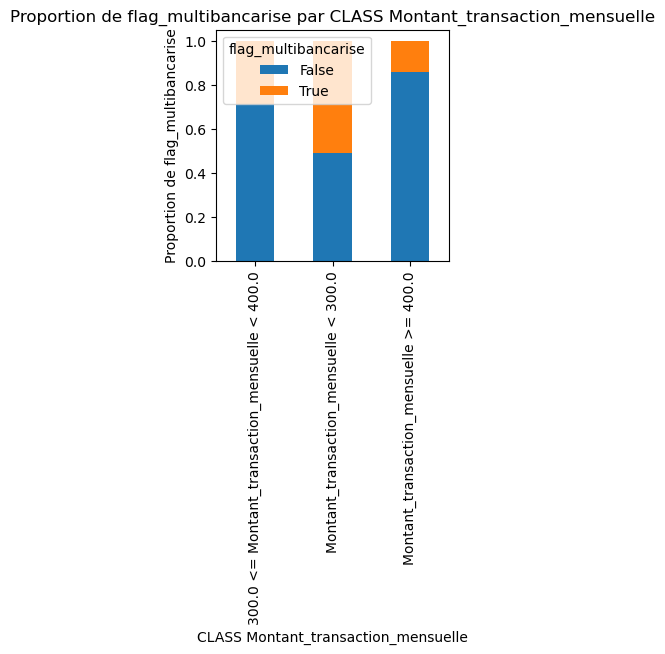


flag_multibancarise                             False  True 
CLASS Montant_transaction_mensuelle                         
300.0 <= Montant_transaction_mensuelle < 400.0   2336    940
Montant_transaction_mensuelle < 300.0            7234   7590
Montant_transaction_mensuelle >= 400.0          38353   6297

Test du Khi-Deux - Chi2 stat: 8536.7296, p-value: 0.0000, df: 2 → Test significatif à 5%
T de Tschuprow : 0.3688
     Relation forte



------------------------------------------------------------------------------------------
Analyse de la variable 'CLASS Nombre_connexion_site_internet'



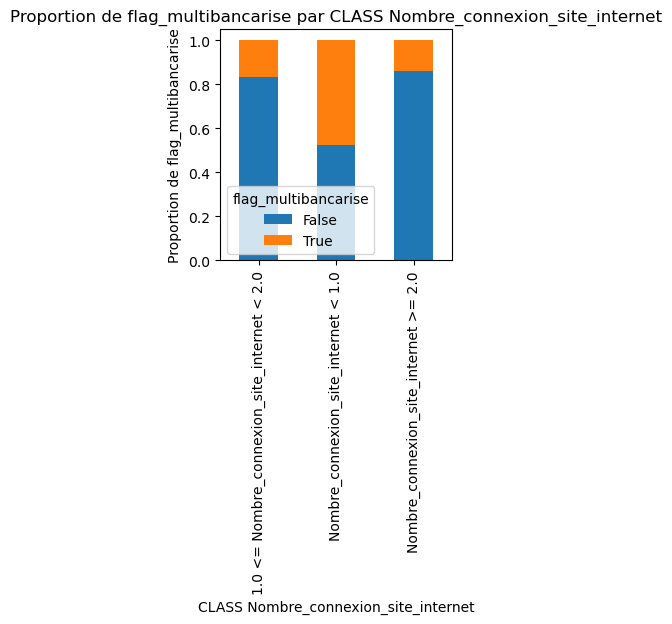


flag_multibancarise                          False  True 
CLASS Nombre_connexion_site_internet                     
1.0 <= Nombre_connexion_site_internet < 2.0   4619    920
Nombre_connexion_site_internet < 1.0          9346   8402
Nombre_connexion_site_internet >= 2.0        33958   5505

Test du Khi-Deux - Chi2 stat: 7729.7225, p-value: 0.0000, df: 2 → Test significatif à 5%
T de Tschuprow : 0.3510
     Relation forte



------------------------------------------------------------------------------------------
Analyse de la variable 'CLASS Nombre_reclamation'



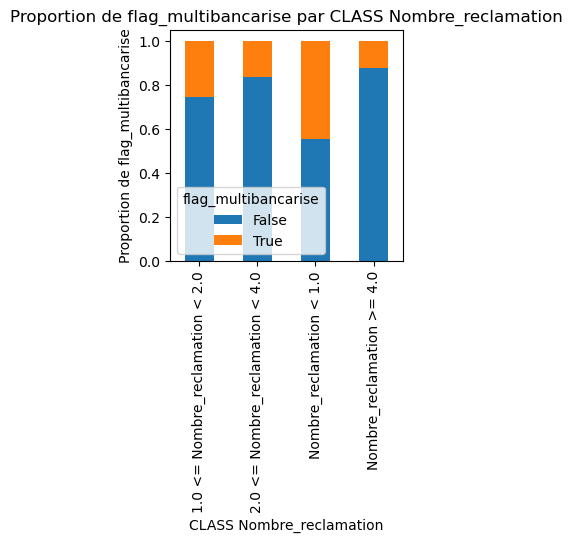


flag_multibancarise              False  True 
CLASS Nombre_reclamation                     
1.0 <= Nombre_reclamation < 2.0   7329   2545
2.0 <= Nombre_reclamation < 4.0  18277   3670
Nombre_reclamation < 1.0          8227   6631
Nombre_reclamation >= 4.0        14090   1981

Test du Khi-Deux - Chi2 stat: 5374.1376, p-value: 0.0000, df: 3 → Test significatif à 5%
T de Tschuprow : 0.2926
     Relation modérée



------------------------------------------------------------------------------------------
Analyse de la variable 'CSP'



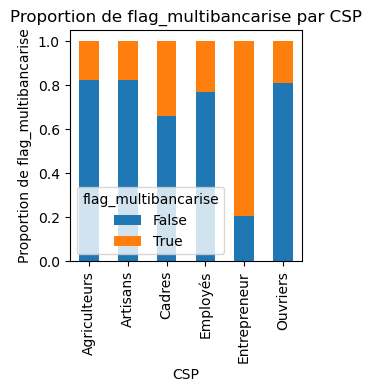


flag_multibancarise  False  True 
CSP                              
Agriculteurs          9276   1970
Artisans              9338   2019
Cadres                5448   2821
Employés              9526   2881
Entrepreneur           480   1884
Ouvriers             13855   3252

Test du Khi-Deux - Chi2 stat: 5273.5474, p-value: 0.0000, df: 5 → Test significatif à 5%
T de Tschuprow : 0.2899
     Relation modérée



------------------------------------------------------------------------------------------
Analyse de la variable 'CLASS Note_satisfaction_2022'



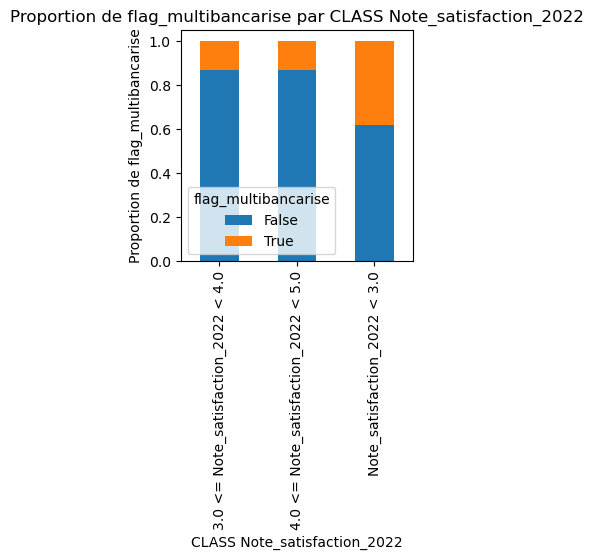


flag_multibancarise                  False  True 
CLASS Note_satisfaction_2022                     
3.0 <= Note_satisfaction_2022 < 4.0  15855   2402
4.0 <= Note_satisfaction_2022 < 5.0  15507   2358
Note_satisfaction_2022 < 3.0         16561  10067

Test du Khi-Deux - Chi2 stat: 5152.3292, p-value: 0.0000, df: 2 → Test significatif à 5%
T de Tschuprow : 0.2865
     Relation modérée



------------------------------------------------------------------------------------------
Analyse de la variable 'CLASS Nombre_virement_application'



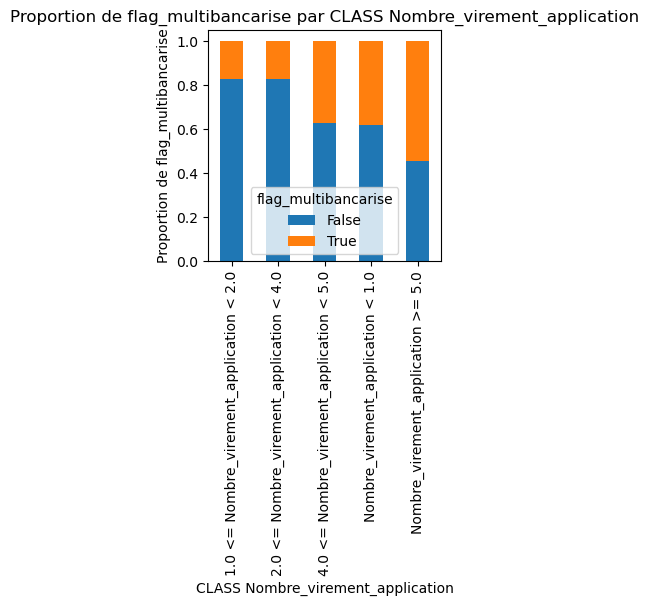


flag_multibancarise                       False  True 
CLASS Nombre_virement_application                     
1.0 <= Nombre_virement_application < 2.0  15769   3251
2.0 <= Nombre_virement_application < 4.0  21742   4458
4.0 <= Nombre_virement_application < 5.0   1258    749
Nombre_virement_application < 1.0          7801   4763
Nombre_virement_application >= 5.0         1353   1606

Test du Khi-Deux - Chi2 stat: 4253.8079, p-value: 0.0000, df: 4 → Test significatif à 5%
T de Tschuprow : 0.2604
     Relation modérée



------------------------------------------------------------------------------------------
Analyse de la variable 'CLASS Nombre_mail'



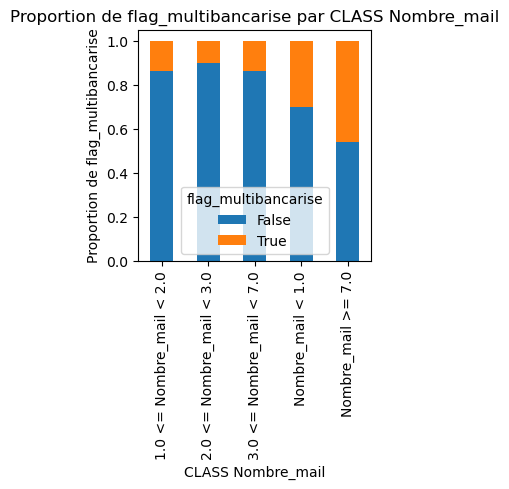


flag_multibancarise       False  True 
CLASS Nombre_mail                     
1.0 <= Nombre_mail < 2.0   8503   1376
2.0 <= Nombre_mail < 3.0   6123    679
3.0 <= Nombre_mail < 7.0   8359   1331
Nombre_mail < 1.0         23274  10029
Nombre_mail >= 7.0         1664   1412

Test du Khi-Deux - Chi2 stat: 3364.6554, p-value: 0.0000, df: 4 → Test significatif à 5%
T de Tschuprow : 0.2316
     Relation modérée



------------------------------------------------------------------------------------------
Analyse de la variable 'CLASS Nombre_compte_investissement'



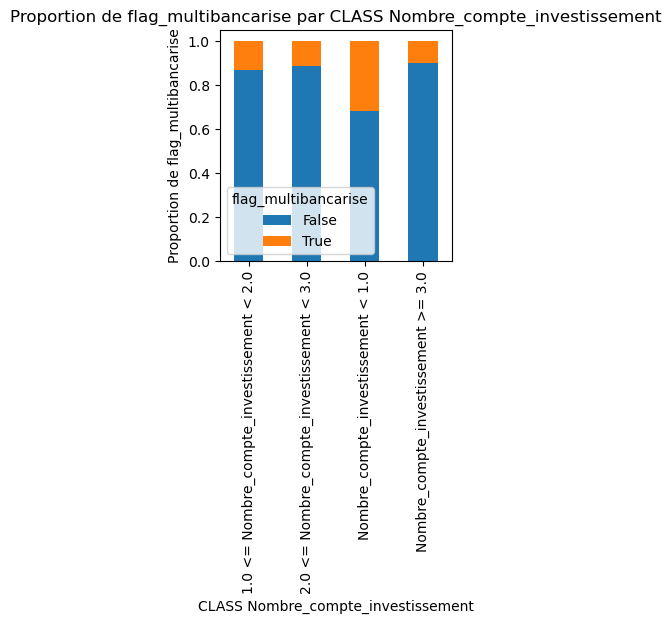


flag_multibancarise                        False  True 
CLASS Nombre_compte_investissement                     
1.0 <= Nombre_compte_investissement < 2.0  15890   2352
2.0 <= Nombre_compte_investissement < 3.0   6053    771
Nombre_compte_investissement < 1.0         24984  11597
Nombre_compte_investissement >= 3.0          996    107

Test du Khi-Deux - Chi2 stat: 3179.8771, p-value: 0.0000, df: 3 → Test significatif à 5%
T de Tschuprow : 0.2251
     Relation modérée



------------------------------------------------------------------------------------------
Analyse de la variable 'CLASS Nombre_compte_epargne'



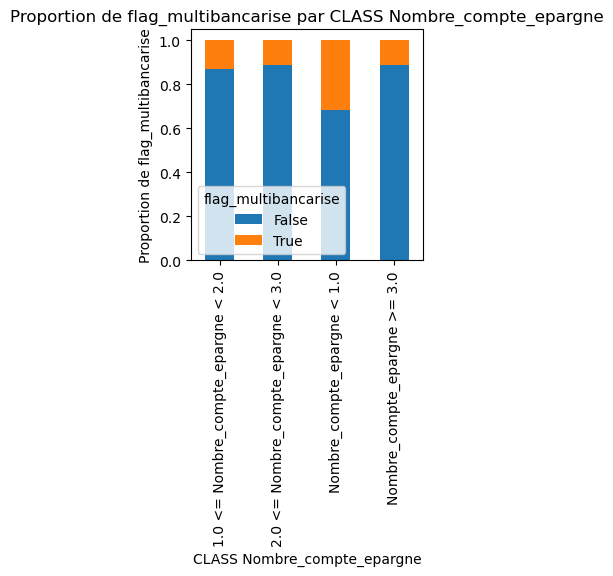


flag_multibancarise                 False  True 
CLASS Nombre_compte_epargne                     
1.0 <= Nombre_compte_epargne < 2.0  15734   2339
2.0 <= Nombre_compte_epargne < 3.0   6104    756
Nombre_compte_epargne < 1.0         25019  11598
Nombre_compte_epargne >= 3.0         1066    134

Test du Khi-Deux - Chi2 stat: 3164.7361, p-value: 0.0000, df: 3 → Test significatif à 5%
T de Tschuprow : 0.2246
     Relation modérée



------------------------------------------------------------------------------------------
Analyse de la variable 'CLASS Revenu'



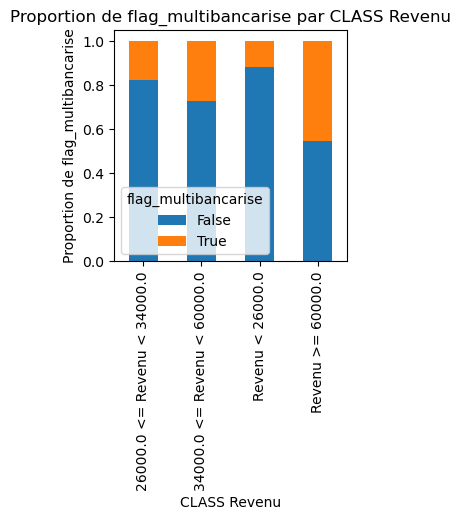


flag_multibancarise          False  True 
CLASS Revenu                             
26000.0 <= Revenu < 34000.0  12585   2703
34000.0 <= Revenu < 60000.0  25246   9472
Revenu < 26000.0              8244   1102
Revenu >= 60000.0             1848   1550

Test du Khi-Deux - Chi2 stat: 2192.6019, p-value: 0.0000, df: 3 → Test significatif à 5%
T de Tschuprow : 0.1869
     Relation modérée



------------------------------------------------------------------------------------------
Analyse de la variable 'CLASS Nombre_carte_classique'



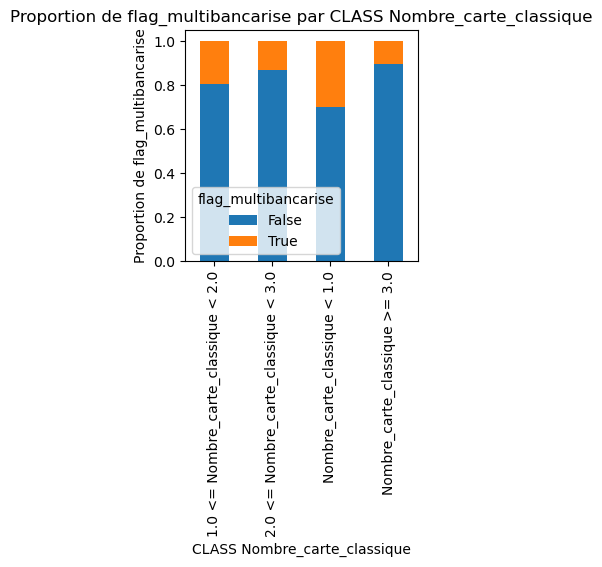


flag_multibancarise                  False  True 
CLASS Nombre_carte_classique                     
1.0 <= Nombre_carte_classique < 2.0  11360   2716
2.0 <= Nombre_carte_classique < 3.0   7318   1087
Nombre_carte_classique < 1.0         24478  10471
Nombre_carte_classique >= 3.0         4767    553

Test du Khi-Deux - Chi2 stat: 1972.1857, p-value: 0.0000, df: 3 → Test significatif à 5%
T de Tschuprow : 0.1773
     Relation modérée



------------------------------------------------------------------------------------------
Analyse de la variable 'CLASS Nombre_cartes'



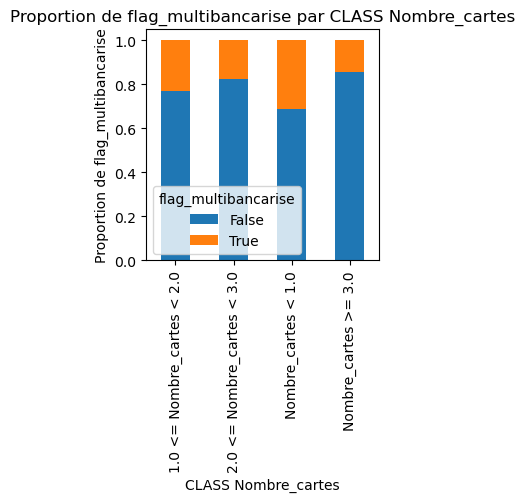


flag_multibancarise         False  True 
CLASS Nombre_cartes                     
1.0 <= Nombre_cartes < 2.0  11459   3380
2.0 <= Nombre_cartes < 3.0   9273   1970
Nombre_cartes < 1.0         17056   7767
Nombre_cartes >= 3.0        10135   1710

Test du Khi-Deux - Chi2 stat: 1600.2300, p-value: 0.0000, df: 3 → Test significatif à 5%
T de Tschuprow : 0.1597
     Relation modérée



------------------------------------------------------------------------------------------
Analyse de la variable 'Niveau_etudes'



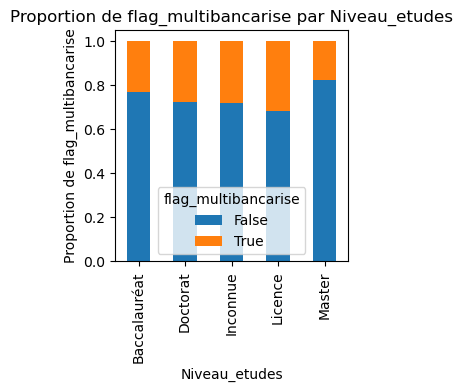


flag_multibancarise  False  True 
Niveau_etudes                    
Baccalauréat          2369    712
Doctorat              9883   3754
Inconnue              4856   1884
Licence               7207   3391
Master               23608   5086

Test du Khi-Deux - Chi2 stat: 1150.6355, p-value: 0.0000, df: 4 → Test significatif à 5%
T de Tschuprow : 0.1354
     Relation modérée



------------------------------------------------------------------------------------------
Analyse de la variable 'CLASS Nombre_virement_site_internet'



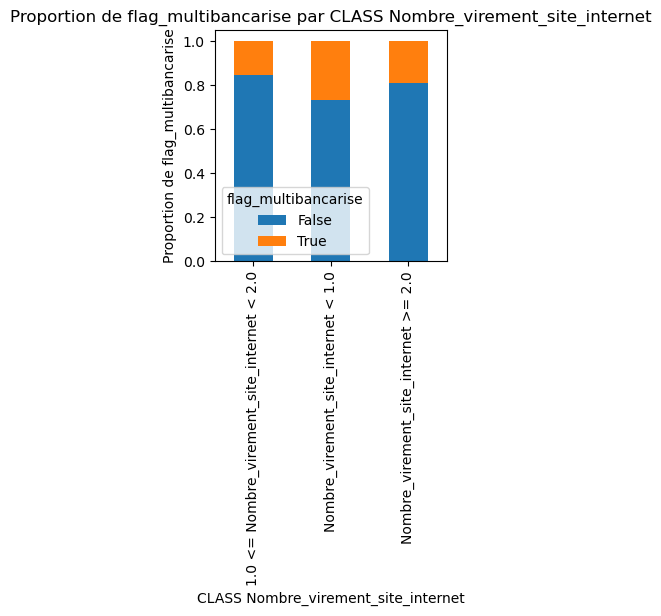


flag_multibancarise                         False  True 
CLASS Nombre_virement_site_internet                     
1.0 <= Nombre_virement_site_internet < 2.0   8974   1629
Nombre_virement_site_internet < 1.0         31868  11567
Nombre_virement_site_internet >= 2.0         7081   1631

Test du Khi-Deux - Chi2 stat: 734.5482, p-value: 0.0000, df: 2 → Test significatif à 5%
T de Tschuprow : 0.1082
     Relation modérée





In [ ]:
columns_quali = data.select_dtypes(include=['category', 'object', 'bool']).columns
resultats = {}

# Étape 1 : Calculer et stocker les métriques pour chaque variable
for column in columns_quali:
    df = data.copy()
    
    # Supprimer les lignes avec des NaN dans la colonne
    df = df.dropna(subset=[column])
    
    # Vérification des effectifs
    nb_modalites = df[column].nunique()
    nb_modalite_valide = (df[column].value_counts() >= 5).sum()
    eff_modalites = bool(nb_modalite_valide / nb_modalites >= 0.8)
    
    # Etude bivariée
    contingency_table = pd.crosstab(df[column], df[cible])

    if nb_modalites == 2 or eff_modalites == False:
        oddsratio, fisher_p = stats.fisher_exact(contingency_table)
        metric = fisher_p  # On va trier par V ou T, mais je garde la p-value pour info
        test_type = "Fisher"
    else:
        chi2_stat, chi2_p, dof, ex = stats.chi2_contingency(contingency_table)
        test_type = "Chi2"

    cramers_v_stat, tschuprow_t = calcul_cramersV_tschuprowT(contingency_table, contingency_table)

    if nb_modalites == 2 and eff_modalites == False:
        metric = cramers_v_stat
    elif nb_modalites > 2 and eff_modalites == True:
        metric = tschuprow_t
    else:
        metric = 0  # Considéré comme non pertinent

    resultats[column] = {
        'contingency_table': contingency_table,
        'nb_modalites': nb_modalites,
        'eff_modalites': eff_modalites,
        'cramers_v': cramers_v_stat,
        'tschuprow_t': tschuprow_t,
        'metric': metric,
        'test_type': test_type
    }

# Étape 2 : Trier les variables par la force de la relation (décroissant)
resultats_tries = dict(sorted(resultats.items(), key=lambda item: item[1]['metric'], reverse=True))

# Filtrer pour ne garder que les variables avec une metric > 0.3
resultats_tries = {k: v for k, v in resultats_tries.items() if v['metric'] > 0.3}

# Étape 3 : Afficher les résultats dans l’ordre trié
for column, infos in resultats_tries.items():
    print('---' * 30)
    print(f"Analyse de la variable '{column}'")
    print()
    contingency_table = infos['contingency_table']

    contingency_table_percentage = contingency_table.div(contingency_table.sum(axis=1), axis=0)
    contingency_table_percentage.plot(kind='bar', stacked=True)
    plt.title(f'Proportion de flag_multibancarise par {column}')
    plt.xlabel(f'{column}')
    plt.ylabel('Proportion de flag_multibancarise')
    plt.gcf().set_size_inches(3, 3)
    plt.show()
    print()

    print(contingency_table)
    print()

    if infos['test_type'] == "Fisher":
        oddsratio, fisher_p = stats.fisher_exact(contingency_table)
        significatif_fisher = "significatif" if fisher_p < 0.05 else "non significatif"
        print(f'Test exact de Fisher - Stat: {oddsratio:.4f}, p-value: {fisher_p:.4f} → Test {significatif_fisher} à 5%')
        print(f"V de Cramer : {infos['cramers_v']:.4f}")
        if infos['cramers_v'] < 0.1: print("     Relation faible")
        elif 0.1 <= infos['cramers_v'] < 0.3: print("     Relation modérée")
        else: print("     Relation forte")
    else:
        chi2_stat, chi2_p, dof, ex = stats.chi2_contingency(contingency_table)
        significatif_chi2 = "significatif" if chi2_p < 0.05 else "non significatif"
        print(f'Test du Khi-Deux - Chi2 stat: {chi2_stat:.4f}, p-value: {chi2_p:.4f}, df: {dof} → Test {significatif_chi2} à 5%')
        print(f"T de Tschuprow : {infos['tschuprow_t']:.4f}")
        if infos['tschuprow_t'] < 0.1: print("     Relation faible")
        elif 0.1 <= infos['tschuprow_t'] < 0.3: print("     Relation modérée")
        else: print("     Relation forte")

    print('\n\n')


# CORRELATION MATRIX

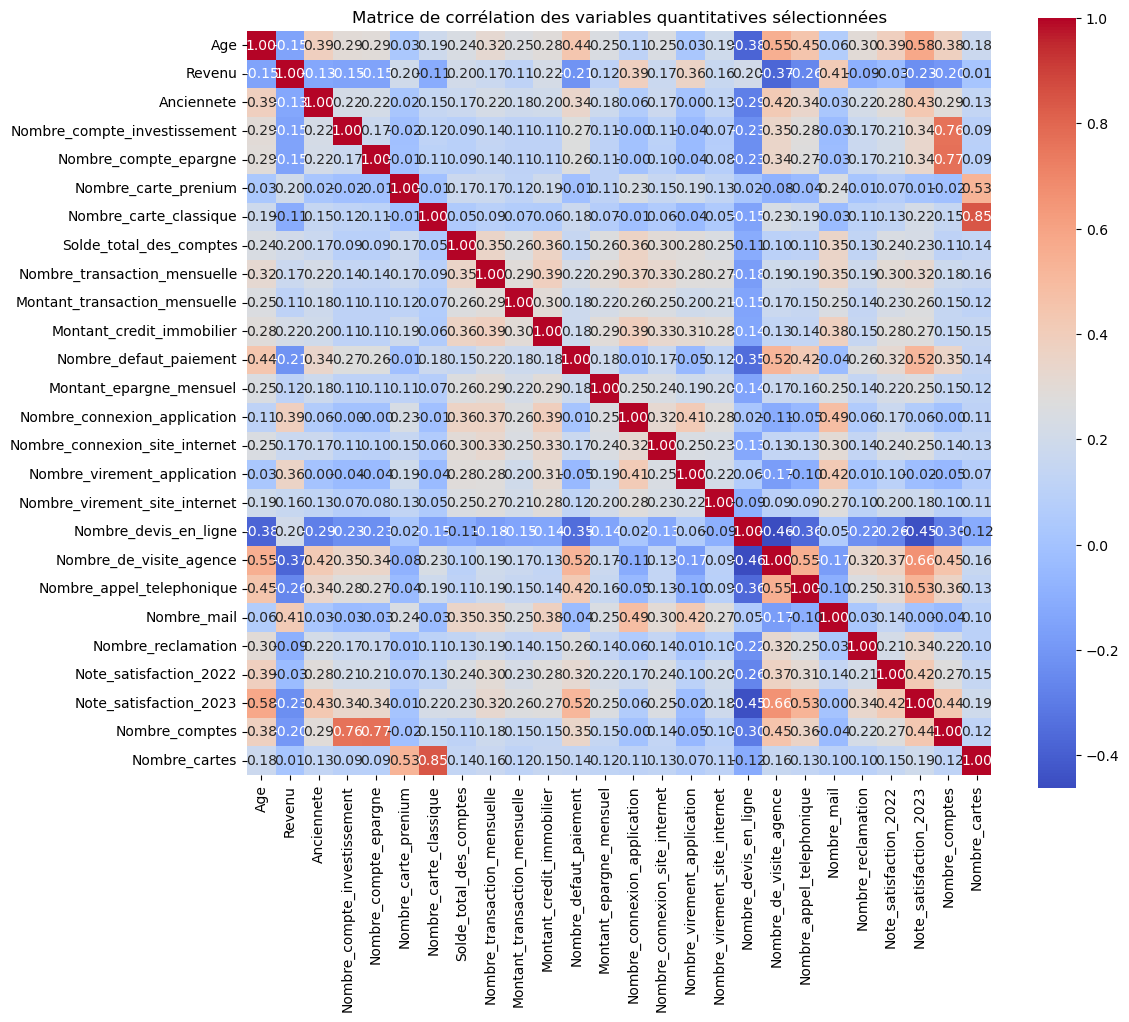

In [22]:
# Exemple : sélection des variables corrélées à la cible
target = 'flag_multibancarise'
threshold = 0.0  # à ajuster selon le contexte

# On sélectionne uniquement les variables quantitatives différentes de la cible
quanti_cols = [col for col in data.select_dtypes(include=['int64', 'float64']).columns if col != target]

# Calcul de la corrélation avec la cible
corr_with_target = data[quanti_cols].corrwith(data[target]).abs()

# On garde uniquement les variables dont la corrélation est significative
selected_vars = corr_with_target[corr_with_target >= threshold].index.tolist()

# Matrice de corrélation réduite
corr_matrix_reduced = data[selected_vars].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_reduced, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Matrice de corrélation des variables quantitatives sélectionnées")
plt.show()


# EXPORTATION DES DONNEES

In [10]:
data_final = data.copy()

# Gestion des noms des colonnes 
data_final.columns = [col.replace('_', ' ').upper() for col in data_final.columns]

# Gestion des variables booléennes
bool_cols = data_final.select_dtypes(include='bool').columns
data_final[bool_cols] = data_final[bool_cols].replace({True: 'Oui', False: 'Non'}).astype('category')


In [11]:
data_final.to_csv('data.csv', index=False, sep=',')

In [12]:
data_final

,AGE,SEXE,CSP,REVENU,NIVEAU ETUDES,PROPRIETAIRE LOCATAIRE,DEPARTEMENT,ANCIENNETE,NOMBRE COMPTE INVESTISSEMENT,NOMBRE COMPTE EPARGNE,...,CLASS NOMBRE VIREMENT SITE INTERNET,CLASS NOMBRE DEVIS EN LIGNE,CLASS NOMBRE DE VISITE AGENCE,CLASS NOMBRE APPEL TELEPHONIQUE,CLASS NOMBRE MAIL,CLASS NOMBRE RECLAMATION,CLASS NOTE SATISFACTION 2022,CLASS NOTE SATISFACTION 2023,CLASS NOMBRE COMPTES,CLASS NOMBRE CARTES
0,53,Femme,Cadres,77845,Master,Locataire,Yvelines,14,1,0,...,1.0 <= Nombre_virement_site_internet < 2.0,Nombre_devis_en_ligne < 1.0,Nombre_de_visite_agence < 1.0,2.0 <= Nombre_appel_telephonique < 3.0,3.0 <= Nombre_mail < 7.0,Nombre_reclamation < 1.0,Note_satisfaction_2022 < 3.0,Note_satisfaction_2023 < 3.0,Nombre_comptes < 1.0,Nombre_cartes < 1.0
1,45,Femme,Agriculteurs,54897,Master,Propriétaire,Hauts-de-Seine,9,0,0,...,Nombre_virement_site_internet < 1.0,Nombre_devis_en_ligne < 1.0,Nombre_de_visite_agence < 1.0,Nombre_appel_telephonique < 2.0,3.0 <= Nombre_mail < 7.0,Nombre_reclamation < 1.0,Note_satisfaction_2022 < 3.0,3.0 <= Note_satisfaction_2023 < 4.0,Nombre_comptes < 1.0,Nombre_cartes < 1.0
2,44,Homme,Cadres,72991,Master,Locataire,Paris,11,0,0,...,1.0 <= Nombre_virement_site_internet < 2.0,1.0 <= Nombre_devis_en_ligne < 2.0,Nombre_de_visite_agence < 1.0,Nombre_appel_telephonique < 2.0,Nombre_mail >= 7.0,Nombre_reclamation < 1.0,3.0 <= Note_satisfaction_2022 < 4.0,3.0 <= Note_satisfaction_2023 < 4.0,Nombre_comptes < 1.0,Nombre_cartes < 1.0
3,41,Femme,Agriculteurs,54050,Doctorat,Propriétaire,Yvelines,13,0,2,...,1.0 <= Nombre_virement_site_internet < 2.0,1.0 <= Nombre_devis_en_ligne < 2.0,Nombre_de_visite_agence < 1.0,Nombre_appel_telephonique < 2.0,Nombre_mail >= 7.0,2.0 <= Nombre_reclamation < 4.0,3.0 <= Note_satisfaction_2022 < 4.0,3.0 <= Note_satisfaction_2023 < 4.0,1.0 <= Nombre_comptes < 2.0,1.0 <= Nombre_cartes < 2.0
4,59,Homme,Artisans,77230,Master,Propriétaire,Paris,1,1,0,...,1.0 <= Nombre_virement_site_internet < 2.0,1.0 <= Nombre_devis_en_ligne < 2.0,Nombre_de_visite_agence < 1.0,Nombre_appel_telephonique < 2.0,Nombre_mail >= 7.0,Nombre_reclamation < 1.0,4.0 <= Note_satisfaction_2022 < 5.0,3.0 <= Note_satisfaction_2023 < 4.0,Nombre_comptes < 1.0,Nombre_cartes >= 3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64367,20,Femme,Employés,49980,Doctorat,Propriétaire,Yvelines,2,0,0,...,Nombre_virement_site_internet < 1.0,1.0 <= Nombre_devis_en_ligne < 2.0,Nombre_de_visite_agence < 1.0,Nombre_appel_telephonique < 2.0,Nombre_mail < 1.0,Nombre_reclamation < 1.0,Note_satisfaction_2022 < 3.0,Note_satisfaction_2023 < 3.0,Nombre_comptes < 1.0,Nombre_cartes < 1.0
64369,33,Femme,Employés,52072,Licence,Locataire,Essonne,1,1,0,...,Nombre_virement_site_internet < 1.0,Nombre_devis_en_ligne < 1.0,Nombre_de_visite_agence < 1.0,Nombre_appel_telephonique < 2.0,Nombre_mail < 1.0,2.0 <= Nombre_reclamation < 4.0,Note_satisfaction_2022 < 3.0,Note_satisfaction_2023 < 3.0,Nombre_comptes < 1.0,Nombre_cartes < 1.0
64370,21,Homme,Artisans,47862,Inconnue,Propriétaire,Yvelines,1,0,1,...,Nombre_virement_site_internet < 1.0,Nombre_devis_en_ligne < 1.0,Nombre_de_visite_agence < 1.0,Nombre_appel_telephonique < 2.0,Nombre_mail < 1.0,2.0 <= Nombre_reclamation < 4.0,Note_satisfaction_2022 < 3.0,Note_satisfaction_2023 < 3.0,Nombre_comptes < 1.0,Nombre_cartes < 1.0
64371,21,Homme,Entrepreneur,41412,Doctorat,Locataire,Yvelines,0,1,1,...,Nombre_virement_site_internet < 1.0,2.0 <= Nombre_devis_en_ligne < 3.0,Nombre_de_visite_agence < 1.0,Nombre_appel_telephonique < 2.0,Nombre_mail < 1.0,Nombre_reclamation < 1.0,Note_satisfaction_2022 < 3.0,Note_satisfaction_2023 < 3.0,1.0 <= Nombre_comptes < 2.0,1.0 <= Nombre_cartes < 2.0
